<a href="https://colab.research.google.com/github/14marcos1/onico/blob/main/onico001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 2025-06-05.png to 2025-06-05 (2).png
Saving 2025-07-04.png to 2025-07-04 (2).png
Saving 2025-08-05.png to 2025-08-05 (2).png
Saving 2025-09-17.png to 2025-09-17 (2).png

4 imagem(ns) carregada(s):
 - 2025-06-05 (2).png
 - 2025-07-04 (2).png
 - 2025-08-05 (2).png
 - 2025-09-17 (2).png
Data da imagem '2025-06-05 (2).png' (ENTER para usar 2025-06-05): 


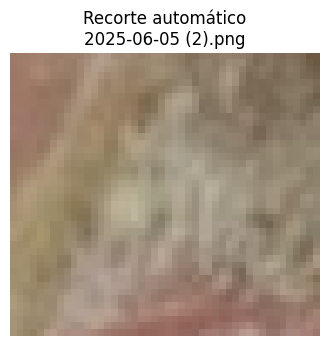

Data da imagem '2025-07-04 (2).png' (ENTER para usar 2025-07-04): 


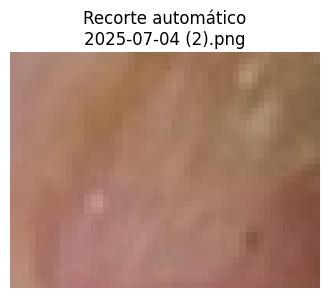

Data da imagem '2025-08-05 (2).png' (ENTER para usar 2025-08-05): 


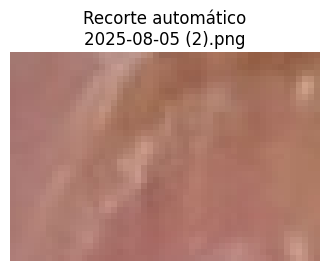

Data da imagem '2025-09-17 (2).png' (ENTER para usar 2025-09-17): 


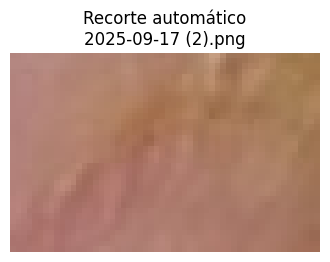


Tabela:


,arquivo,data,indice_amarelo_%
0,2025-06-05 (2).png,2025-06-05,64.803313
1,2025-07-04 (2).png,2025-07-04,9.368421
2,2025-08-05 (2).png,2025-08-05,0.000000
3,2025-09-17 (2).png,2025-09-17,4.761905


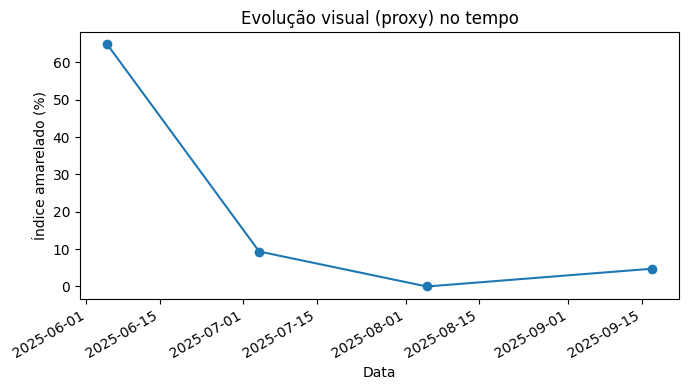

Defina o limiar (%) para 'quase normal' [padrão=10]: 10

Ajuste linear: indice = -0.5129 * dias + 44.61
Estimativa (aprox.) de atingir 10.0%: 2025-08-11 (~67 dias após o início)


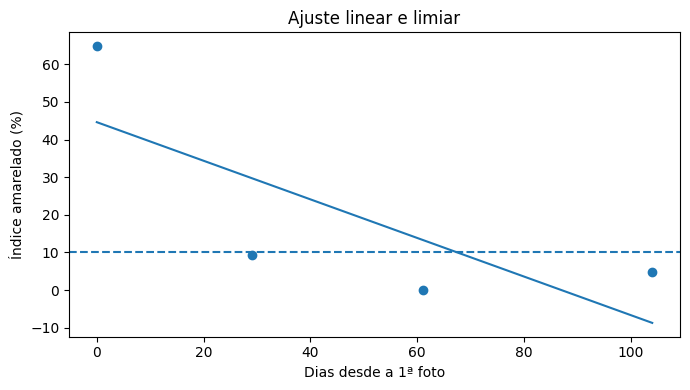

In [ ]:
# ==========================================
# Colab: Acompanhamento visual de onicomicose
# (sem cliques / sem ginput) - 100% automático
# ==========================================
# O que faz:
# 1) Upload das imagens
# 2) Para cada imagem, você informa a data (YYYY-MM-DD) (ou ele tenta ler do nome)
# 3) Faz um recorte automático central (evita travar no Colab)
# 4) Calcula um "índice amarelado (%)" dentro do recorte (proxy de lesão)
# 5) Plota evolução no tempo e estima quando cruza um limiar (ex.: 10%)

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

# -------- Upload --------
uploaded = files.upload()
paths = [p for p in uploaded.keys() if re.search(r"\.(png|jpg|jpeg|webp)$", p, re.I)]

if len(paths) == 0:
    raise RuntimeError("Nenhuma imagem detectada. Envie .png/.jpg/.jpeg/.webp")

print(f"\n{len(paths)} imagem(ns) carregada(s):")
for p in sorted(paths):
    print(" -", p)

# -------- Utils --------
def pil_to_np_rgb(pil_img: Image.Image) -> np.ndarray:
    return np.array(pil_img.convert("RGB"))

def rgb_to_hsv_np(rgb: np.ndarray) -> np.ndarray:
    """RGB [0..255] -> HSV [0..1] (vetorizado)"""
    rgb = rgb.astype(np.float32) / 255.0
    r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]
    cmax = np.max(rgb, axis=-1)
    cmin = np.min(rgb, axis=-1)
    delta = cmax - cmin

    h = np.zeros_like(cmax)
    s = np.zeros_like(cmax)
    v = cmax.copy()

    # Saturation
    s[cmax != 0] = delta[cmax != 0] / (cmax[cmax != 0] + 1e-8)

    # Hue
    mask = delta != 0
    rc = (((g - b) / (delta + 1e-8)) % 6)
    gc = (((b - r) / (delta + 1e-8)) + 2)
    bc = (((r - g) / (delta + 1e-8)) + 4)

    rmask = mask & (cmax == r)
    gmask = mask & (cmax == g)
    bmask = mask & (cmax == b)

    h[rmask] = rc[rmask]
    h[gmask] = gc[gmask]
    h[bmask] = bc[bmask]
    h = h / 6.0  # 0..1

    return np.stack([h, s, v], axis=-1)

def yellow_index(hsv: np.ndarray) -> float:
    """
    Proxy simples: fração de pixels "amarelados" no recorte.
    Ajuste depois se desejar.
    """
    h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    # Faixa ampliada de amarelo (tolerante a variações)
    yellow = (h >= 0.08) & (h <= 0.22) & (s >= 0.18) & (v >= 0.35)
    return float(np.mean(yellow)) * 100.0

def try_parse_date_from_filename(fname: str):
    m = re.search(r"(20\d{2})[-_](\d{2})[-_](\d{2})", fname)
    if not m:
        return None
    try:
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}", format="%Y-%m-%d")
    except Exception:
        return None

def ask_date(fname: str) -> pd.Timestamp:
    guessed = try_parse_date_from_filename(fname)
    if guessed is not None:
        s = input(f"Data da imagem '{fname}' (ENTER para usar {guessed.date()}): ").strip()
        if s == "":
            return guessed

    while True:
        s = input(f"Data da imagem '{fname}' (YYYY-MM-DD): ").strip()
        try:
            return pd.to_datetime(s, format="%Y-%m-%d")
        except Exception:
            print("Formato inválido. Use YYYY-MM-DD (ex.: 2025-06-05).")

def auto_crop(rgb: np.ndarray, x1p=0.25, x2p=0.75, y1p=0.30, y2p=0.80) -> np.ndarray:
    """
    Recorte automático central.
    Ajuste os percentuais se o dedo não estiver bem centralizado.
    """
    h, w, _ = rgb.shape
    x1 = int(w * x1p); x2 = int(w * x2p)
    y1 = int(h * y1p); y2 = int(h * y2p)
    crop = rgb[y1:y2, x1:x2]
    if crop.size == 0:
        raise RuntimeError("Recorte automático vazio. Ajuste os percentuais do auto_crop().")
    return crop

# -------- Loop principal --------
rows = []
for fname in sorted(paths):
    img = Image.open(fname)
    rgb = pil_to_np_rgb(img)

    date = ask_date(fname)

    # Recorte automático (sem cliques)
    crop = auto_crop(rgb)

    # Opcional: reduzir tamanho para acelerar
    if crop.shape[1] > 500:
        scale = 500 / crop.shape[1]
        new_w = 500
        new_h = int(crop.shape[0] * scale)
        crop = np.array(Image.fromarray(crop).resize((new_w, new_h)))

    # Visualizar recorte
    plt.figure(figsize=(4, 4))
    plt.imshow(crop)
    plt.title(f"Recorte automático\n{fname}")
    plt.axis("off")
    plt.show()

    hsv = rgb_to_hsv_np(crop)
    idx = yellow_index(hsv)

    rows.append({"arquivo": fname, "data": date, "indice_amarelo_%": idx})

df = pd.DataFrame(rows).sort_values("data").reset_index(drop=True)
print("\nTabela:")
display(df)

# -------- Curva temporal --------
df["dias_desde_inicio"] = (df["data"] - df["data"].min()).dt.days.astype(int)

plt.figure(figsize=(7, 4))
plt.plot(df["data"], df["indice_amarelo_%"], marker="o")
plt.xlabel("Data")
plt.ylabel("Índice amarelado (%)")
plt.title("Evolução visual (proxy) no tempo")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# -------- Estimar quando cruza um limiar --------
x = df["dias_desde_inicio"].to_numpy().astype(float)
y = df["indice_amarelo_%"].to_numpy().astype(float)

if len(df) >= 2:
    a, b = np.polyfit(x, y, 1)

    limiar_str = input("Defina o limiar (%) para 'quase normal' [padrão=10]: ").strip()
    limiar = float(limiar_str) if limiar_str else 10.0

    if abs(a) < 1e-8:
        print("\nInclinação ~0; não dá para estimar queda até o limiar.")
    else:
        x_pred = (limiar - b) / a
        data_pred = df["data"].min() + pd.to_timedelta(int(round(x_pred)), unit="D")

        print(f"\nAjuste linear: indice = {a:.4f} * dias + {b:.2f}")
        print(f"Estimativa (aprox.) de atingir {limiar:.1f}%: {data_pred.date()} (~{int(round(x_pred))} dias após o início)")

        xx = np.linspace(x.min(), max(x.max(), x_pred), 120)
        yy = a * xx + b

        plt.figure(figsize=(7, 4))
        plt.scatter(x, y)
        plt.plot(xx, yy)
        plt.axhline(limiar, linestyle="--")
        plt.xlabel("Dias desde a 1ª foto")
        plt.ylabel("Índice amarelado (%)")
        plt.title("Ajuste linear e limiar")
        plt.tight_layout()
        plt.show()
else:
    print("\nPoucos pontos para estimar tendência.")
